In [ ]:
import eumdac
import geopandas as gpd
from datetime import datetime, timedelta
import os
import shutil
from shapely.geometry import Polygon, mapping


In [2]:
import xarray as xr

ds= xr.open_dataset("/media/BIFROST/N2/Riccardo/MSG/msg_data/batch_2/processed/final_ndvi.nc", 
                    chunks={"time":"250MB"})

In [3]:
ds = ds.assign(day = ds["time"].dt.dayofyear)

In [4]:
from p_drought_indices.functions.ndvi_functions import clean_outliers

In [5]:
ds = clean_outliers(ds)

In [11]:
from p_drought_indices.functions.function_clns import cut_file, subsetting_pipeline, load_config
import geopandas as gpd
from shapely.geometry import Polygon, mapping


CONFIG_PATH= "../config.yaml"
countries = ["Ethiopia"]
config = load_config(CONFIG_PATH)
shapefile_path = config['SHAPE']['HOA']
gdf = gpd.read_file(shapefile_path)
subset = gdf[gdf.ADM0_NAME.isin(countries)]
new_ds = cut_file(ds, subset)
new_ds = new_ds.resample(time='7D', skipna=True).mean()

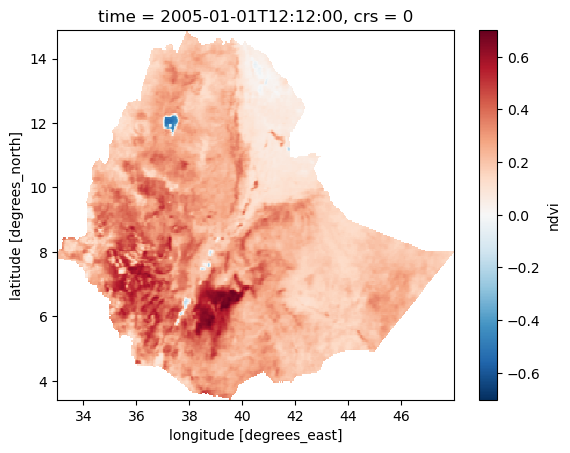

In [7]:
new_ds.isel(time=0)["ndvi"].plot()

In [30]:
df = new_ds.to_dataframe()

In [31]:
df = df.reset_index().dropna(subset=["ndvi"])

In [34]:
df["land"].unique()

array([ 20.,  30.,  nan,  90., 126., 124., 114., 112., 116.,  40.,  60.,
        80.,  50.], dtype=float32)

In [27]:
from p_drought_indices.ancillary_vars.esa_landuse import get_level_colors
def prepare(ds):
        ds.rio.write_crs("epsg:4326", inplace=True)
        ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
        return ds

def get_land_cover(ds, countries, ds_path= r'../data/images/esa_cover.nc'):
    ds_cover = xr.open_dataset(ds_path)
    ds_cover = prepare(ds_cover)
    ds_cover = subsetting_pipeline(CONFIG_PATH, ds_cover,countries, invert=False)
    #### get categories and levels with colors to plot the land cover dataset
    cmap, levels = get_level_colors(ds_cover)
    land_categories = ds_cover.to_dataframe()['Band1'].dropna().astype(int).unique().tolist()
    #### reproject land cover ds in the format of the precipitation dataset
    res = ds_cover['Band1'].rio.reproject_match(ds["ndvi"])
    res = res.rename({'x':'lon','y':'lat'})
    #### generate empty time dimension and expand it
    time_dim = ds['time'].values
    time_da = xr.DataArray(time_dim, [('time', time_dim)])
    res = res.expand_dims(time=time_da)
    ds = ds.assign(land = res)
    return ds

In [28]:
new_ds = get_land_cover(new_ds, countries)
new_ds

<xarray.Dataset>
Dimensions:  (lon: 342, lat: 262, time: 812)
Coordinates:
  * lon      (lon) float64 33.03 33.08 33.12 33.17 ... 47.83 47.88 47.92 47.96
  * lat      (lat) float64 3.437 3.481 3.524 3.568 ... 14.73 14.78 14.82 14.86
    crs      int64 0
  * time     (time) datetime64[ns] 2005-01-01 2005-01-08 ... 2020-07-18
Data variables:
    ndvi     (time, lat, lon) float32 dask.array<chunksize=(1, 262, 342), meta=np.ndarray>
    day      (time) float64 4.0 11.0 18.0 25.0 32.0 ... 182.0 189.0 196.0 203.0
    land     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

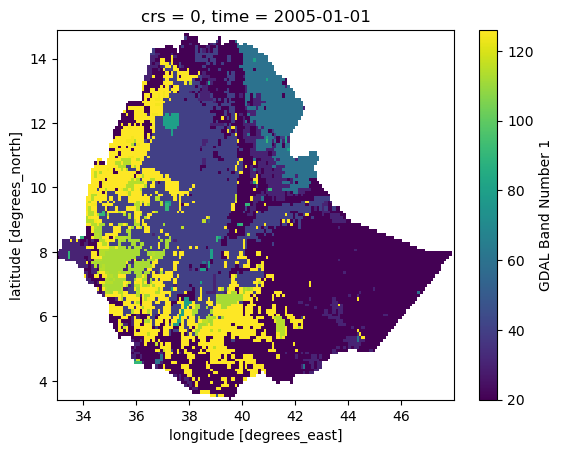

In [29]:
new_ds["land"].isel(time=0).plot()

In [ ]:
import numpy as np
from configparser import ConfigParser
from mpop import CONFIG_PATH
import os
import yaml

from netCDF4 import Dataset

In [ ]:
def load_config(CONFIG_PATH):
    with open(CONFIG_PATH) as file:
        config = yaml.safe_load(file)
        return config

import os

CONFIG_PATH = r"./config.yaml"


config = load_config(CONFIG_PATH)

# Insert your personal key and secret into the single quotes
consumer_key = config['DEFAULT']['key']
consumer_secret = config['DEFAULT']['secret']

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

print(f"This token '{token}' expires {token.expiration}")

In [ ]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:METOP:SOMO25')


In [ ]:
from IPython.core.display import HTML 
# Display the details for the selected collection
display(HTML('<b>'+selected_collection.title+'</b>'))
display(HTML('<b>ID:</b> '+str(selected_collection)))
display(HTML('<b>Abstract:</b> '+selected_collection.abstract))

In [ ]:
collectionID ='EO:EUM:DAT:MSG:HRSEVIRI'

datastore = eumdac.DataStore(token)
datastore.collections

selected_collection = datastore.get_collection(collectionID)
bbox =[32.9, 3.2, 48, 15]
#products = selected_collection.search(bbox=bbox) 

In [ ]:
# Add vertices for polygon, wrapping back to the start point.
geometry = [[15,32.8],[2.9,32.8],[2.9,48],[48,15], [15,32.8]]

download_dir = r'C:\Users\Riccardo\Desktop\PhD docs\Drought prediction\dataset\EUMETSAT\MSG'

start_date = '2009-01-01 11:45:00'
end_date= '2020-01-01 12:20:00'

start_dt = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_dt = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
delta = timedelta(days=1)
time_window = timedelta(minutes=30)

while start_dt <= end_dt:  
    limit_dt = start_dt + time_window
    # Retrieve datasets that match our filter
    product = selected_collection.search(
        geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in geometry])),
        #bbox=bbox,
        dtstart=start_dt, 
        dtend=limit_dt).first()
        
    selected_product = datastore.get_product(product_id=str(product), collection_id=collectionID)
    
    try:
        with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
            #print(f'Downloading {fsrc.name}')
            shutil.copyfileobj(fsrc, fdst)
            print(f'Download of product {fsrc.name} finished.')
        
    except Exception as e:
        print('http error {} on day'.format(e), datetime.strftime(start_dt, format='%Y-%m-%d %H:%M:%S'))
    
    start_dt += delta


2011-03-11

In [ ]:
path = r'C:\Users\Riccardo\Desktop\PhD docs\Drought prediction\ETH_adm\gadm40_ETH_0.shp'
eth_poly = gpd.read_file(path)


### Processing files

In [ ]:
from satpy import DataQuery
from pyresample.geometry import SwathDefinition
from satpy import Scene
import xarray as xr
import geopandas as gpd
from satpy.dataset import combine_metadata
import matplotlib.pyplot as plt
from glob import glob
import os
import datetime as datetime

In [ ]:
from satpy import Scene

base_dir = r'D:\MSG\MSG_nat\batch_2'
file = r'MSG2-SEVI-MSG15-0100-NA-20110311121242.259000000Z-NA.nat'
scn =Scene(filenames = {reader:[os.path.join(base_dir,file)]})

In [ ]:
from epct import api

#fine the configuration of the functional chain to apply:
chain_config = {
       'name': 'sample_chain',
       'product': 'HRSEVIRI',
       'format': 'netcdf4',
       'projection': 'geographic',
   }

base_dir = r'D:\MSG\MSG_nat\batch_2'

files = [f for f in os.listdir(base_dir) if f.endswith('.nat')]

with open(r'C:\Users\Riccardo\Desktop\PhD_docs\Drought_prediction\ETH_adm.zip', 'rb') as f:
     shapefile_stream = f.read()

target_dir = r'D:\MSG\msg_data\batch_2'
#n the chain and return the result as an `xarray` object
output_xarray_dataset = api.run_chain_to_xarray(
   product_paths=[r'D:\\MSG\MSG_nat\batch_2\MSG2-SEVI-MSG15-0100-NA-20110311121242.259000000Z-NA.nat'],
   chain_config=chain_config,
   target_dir=target_dir,
   shapefile_stream=shapefile_stream
)

In [ ]:
lon, lat = scn[0.8].attrs['area'].get_lonlats()
swath_def = SwathDefinition(lons=lon, lats=lat)

In [ ]:
def compute_ndvi(scn):
    #lon, lat = scn[0.8].attrs['area'].get_lonlats()
    ndvi = (scn[0.8] - scn[0.6]) / (scn[0.8] + scn[0.6])
    ndvi.attrs = combine_metadata(scn[0.8], scn[0.6])
    scn['ndvi'] = ndvi
    return scn

def from_nat_netcdf(file, reader = "seviri_l1b_native"):
    scn =Scene(filenames = {reader:[file]})
    #dataset_names = scn.all_dataset_names()
    my_channel_id = DataQuery(name=['VIS006'], calibration='reflectance')
    my_channel_id_2 = DataQuery(name=['VIS008'], calibration='reflectance')
    scn.load([my_channel_id, my_channel_id_2])
    scn_ndvi = compute_ndvi(scn)
    return scn_ndvi

### Cut Ethiopia and convert to xarray

In [ ]:
import geopandas as gpd
path = r'C:\Users\Riccardo\Desktop\PhD_docs\Drought_prediction\ETH_adm\gadm40_ETH_0.shp'
eth_poly = gpd.read_file(path)


In [ ]:
from epct import api

# define the configuration of the functional chain to apply:
chain_config = {
       'name': 'sample_chain',
       'product': 'HRSEVIRI',
       'format': 'netcdf4',
       'projection': 'geographic'}

#ecify the input product paths and load the shapefile
input_products = [
    r'D:\MSG\MSG_nat\batch_2\msg2_sevi.nat',
    ]

with open(r'C:\Users\Riccardo\Downloads\gadm40_ETH_shp.zip', 'rb') as f:
    shapefile_stream = f.read()


#n the chain and return the result as an `xarray` object
output_xarray_dataset = api.run_chain_to_xarray(
   product_paths=input_products,
   chain_config=chain_config,
   target_dir=r'D:\MSG\msg_data\batch_2',
   shapefile_stream=shapefile_stream
)


In [ ]:
os.path.join(base_dir,file)

In [ ]:
from epct import api
import os
import xarray as xr

chain_config = {"filter": "hrseviri_natural_color",
        "name": "Natural color disc",
        "id": "natural_color_disc",
        'product': 'HRSEVIRI',
        'format': 'netcdf4',
        'projection': 'geographic'
    }

#input_products = [
#     r'D:\MSG\msg_data\MSG2-SEVI-MSG15-0100-NA-20090108121240.961000000Z-NA.nat'
# ]

#files = glob('D:\MSG\msg_data\*.nat')
base_dir = r'D:\MSG\MSG_nat\batch_1'
files = [f for f in os.listdir(base_dir) if f.endswith('.nat')]

with open(r'C:\Users\Riccardo\Desktop\PhD_docs\Drought_prediction\gadm40_ETH_shp.zip', 'rb') as f:
     shapefile_stream = f.read()

for file in files:
    # run the chain and return the result as an `xarray` object
    output_xarray_dataset = api.run_chain_to_xarray(
       product_paths=[os.path.join(base_dir,file)],
       chain_config=chain_config,
       target_dir=r'D:\MSG\msg_data\batch_2',
       shapefile_stream=shapefile_stream
    )

In [ ]:
files

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import os

def add_time(xr_df):
    my_date_string = xr_df.attrs['date_time'] 
    date_xr = datetime.strptime(my_date_string, '%Y%m%d/%H:%M')
    date_xr = pd.to_datetime(date_xr)
    xr_df = xr_df.assign_coords(time=date_xr)
    xr_df = xr_df.expand_dims(dim="time")
    return xr_df

def compute_radiance(xr_df):
    satellite = xr_df.attrs['EPCT_product_name'][:4]
    if satellite == 'MSG2':
        xr_df['channel_1'] = xr_df['channel_1']/65.2065
        xr_df['channel_2'] = xr_df['channel_2']/73.0127
        
    elif satellite == 'MSG1':
        xr_df['channel_1'] = xr_df['channel_1']/65.2296 
        xr_df['channel_2'] = xr_df['channel_2']/73.1869
    
    else:
        print('This product doesn\'t contain MSG1 or MSG2 Seviri')
    
    return xr_df
        

base_dir = r'D:\MSG\msg_data\netcdf_data'
files = [f for f in os.listdir(base_dir) if f.endswith('.nc')]

for file in files:
    with xr.open_dataset(os.path.join(base_dir, file)) as ds:
        data = ds.load()
        xr_df = add_time(data)
        xr_df = compute_radiance(xr_df)
        xr_df = xr_df.drop('channel_3')
        xr_df = xr_df.assign(ndvi=(xr_df['channel_2'] - xr_df['channel_1']) / (xr_df['channel_2'] + xr_df['channel_1']))
        #xr_df['channel_2'].plot()
        xr_df.to_netcdf(os.path.join(base_dir,'processed', file)) 
        xr_df.close()

### Plot the average NDVI per month

In [ ]:
import sys
print(sys.prefix)

In [ ]:
import xarray as xr
base_dir = r'D:\MSG\msg_data\netcdf_data\processed'
file = 'HRSEVIRI_20090101T121200Z_20090101T121200Z_epct_c0b84031_FP.nc'
xr_df = xr.open_dataset(os.path.join(base_dir, file))

In [ ]:
xr_df['channel_1'].plot()

In [ ]:
xr_df['channel_2'].plot()

In [ ]:
xr_df['ndvi'].plot()

### Cloudmask dataset

In [ ]:
import xarray as xr
import os
base_dir = r'D:\MSG\cloudmask\processed_clouds'
file = 'MSGCLMK_20100115T121500Z_20100115T121500Z_epct_82eea5af_P.nc'
xr_df = xr.open_dataset(os.path.join(base_dir, file))
xr_df

In [ ]:
xr_df['cloud_mask'].plot()

In [ ]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt

def downsample(ds):
    monthly = ds.resample(time='5D', skipna=True).mean()
    return monthly

def clean_ndvi(ds):
    ds = ds.where('ndvi'!=0.00)
    return ds

base_dir = r'D:\MSG\msg_data\netcdf_data\processed'
ds = xr.open_mfdataset(os.path.join(base_dir,'*.nc'))
clouds_dir = r'D:\MSG\cloudmask\processed_clouds'
ds_cl = xr.open_mfdataset(os.path.join(clouds_dir,'time','*.nc'))

In [ ]:
### normalize time in order for the two datasets to match
ds_cl['time'] = ds_cl.indexes['time'].normalize()
ds['time'] = ds.indexes['time'].normalize()

### apply time mask
ds = ds.where(ds.time == ds_cl.time)

### apply mask and downsample to 5 days
res_xr = ds.where(ds_cl.cloud_mask<2)
res_xr_p = downsample(res_xr)

### mask all the values equal to 0 (clouds)
mask_clouds = clean_ndvi(ds)
mask_clouds_p = downsample(mask_clouds)

In [ ]:
time = '2009-12-05'
#print('')
ds['ndvi'].sel(time=time, method = 'nearest').plot()
plt.title('Default NDVI image no cloud correction')
plt.show()
mask_clouds_p['ndvi'].sel(time=time,  method = 'nearest').plot()
plt.title('NDVI image with max pixel value cloud correction')
plt.show()
res_xr_p['ndvi'].sel(time=time,  method = 'nearest').plot()
plt.title('NDVI image with cloud mask')
plt.show()
ds_cl['cloud_mask'].sel(time=time,  method = 'nearest').plot()
plt.title('Cloud mask')
plt.show()

### Difference in absolute value

In [ ]:
res = mask_clouds_p['ndvi'].isel(time=0) - res_xr_p['ndvi'].isel(time=0)

In [ ]:
res.plot()

In [ ]:
mask_clouds['ndvi'].sum(res_xr['ndvi'])

In [ ]:
diff = mask_clouds['ndvi'] res_xr['ndvi']
diff_p = mask_clouds_p['ndvi'] - res_xr_p['ndvi']

In [ ]:
abs(diff).mean('time', skipna=True).plot()
plt.show()

abs(diff_p).mean('time').plot()
plt.show()

### Check correlation

In [ ]:
import xskillscore as xs

# Selecting variables from the dataarray...................................
ndvi_= res_xr['ndvi'].chunk(dict(time=-1))
mask_= mask_clouds['ndvi'].chunk(dict(time=-1))

xs.pearson_r(ndvi_, mask_, dim='time', skipna=True).plot()
plt.show()

# Selecting variables from the dataarray...................................
ndvi_= res_xr_p['ndvi'].chunk(dict(time=-1))
mask_= mask_clouds_p['ndvi'].chunk(dict(time=-1))

xs.pearson_r(ndvi_, mask_, dim='time', skipna=True).plot()
plt.show()